# Recovering statistics from edge-sampled networks

In this notebook we will investigate empirically how different statistics behave on networks that are edge-sampled, without any temporal analysis for the moment

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from collections import Counter
a4_dims = (11.69,8.27)

Simple function which returns from a given networkx graph G a graph H, the induced subgraph from a random proportion p of H's edges.

In [2]:
def edge_sample(G, p):
    edges = G.edges()
    sampled=[]
    for e in edges:
        r = random.random()
        if r < p:
            sampled.append(e)
    H = nx.Graph()
    H.add_edges_from(sampled)
    return H

Returns a vector of degrees and cdf from a networkx graph G

In [3]:
def get_deg_cdf(G):
    cts = Counter(sorted([d for n, d in G.degree()]))
    degs = sorted(cts.keys())
    vals = [cts[val] for val in degs]
    cdf = np.cumsum(vals)
    ccdf = cdf[-1] - cdf
    return degs, cdf

More generally returns an empirical cdf of values 

In [4]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum

In [5]:
def setup_axes(x,y,xscale="linear",yscale="linear"):
    fig, ax = plt.subplots(figsize = a4_dims)
    ax.set_xlabel(x,fontsize=20)
    ax.set_ylabel(y, fontsize=20)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    return fig, ax

In [6]:
#G = nx.gnp_random_graph(1000, 0.005)
G = nx.barabasi_albert_graph(10000,3)
n = len(G.nodes())
m = len(G.edges())
k = 2*m/n
print(m)

29991


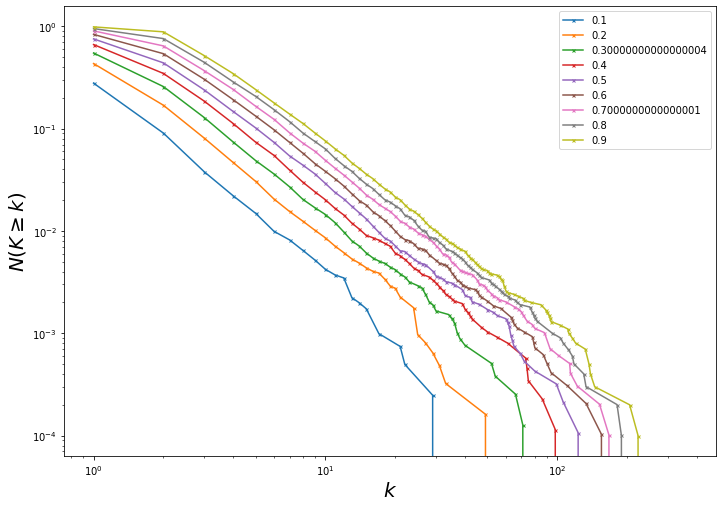

In [7]:
prange = np.linspace(0.1,0.9,9)
edges = G.edges()

fig, ax = setup_axes('$k$','$N(K\\geq k)$','log','log')

for p in prange:
    H = edge_sample(G,p)
    degs, cdf = get_deg_cdf(H)
    ccdf = 1-cdf/cdf[-1]
    ax.plot(degs, ccdf,marker='x',markersize=3,label=str(p))
    
ax.legend()
plt.show()

Estimate the original degree by using the estimator ki = 1/p * ki'.

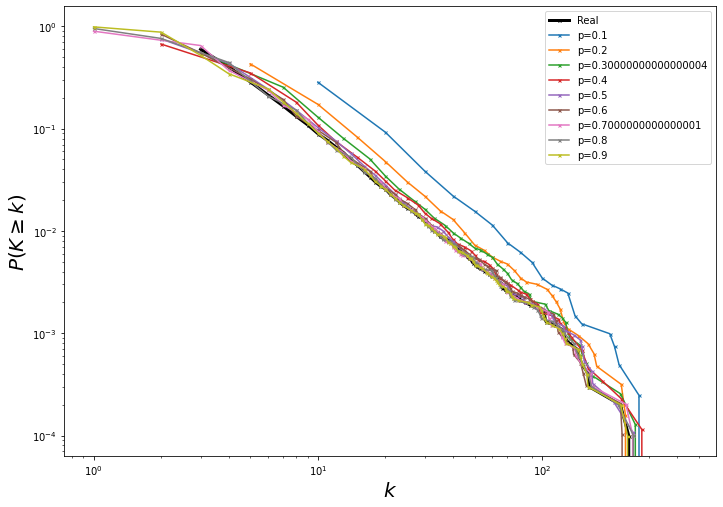

In [8]:
prange = np.linspace(0.1,0.9,9)
edges = G.edges()

fig, ax = setup_axes('$k$','$P(K\\geq k)$','log','log')

degs, cdf = get_deg_cdf(G)
ccdf = 1 - cdf/cdf[-1]
ax.plot(degs, ccdf,marker='x',markersize=3,label="Real", linewidth=3, color="black")

for p in prange:
    H = edge_sample(G,p)
    degrees = [d for n,d in nx.degree(H)]
    rescaled = sorted([np.round(d/p) for d in degrees])
    degs, cdf = ecdf(rescaled)
#     cts = Counter(rescaled)
#     degs = sorted(cts.keys())
#     vals = [cts[val] for val in degs]
#     cdf = np.cumsum(vals)
    ccdf = cdf[-1] - cdf
    ccdf = 1-cdf/cdf[-1]
    ax.plot(degs, ccdf,marker='x',markersize=3,label="p="+str(p))
    
ax.legend()
plt.show()

Too harsh to use this MLE. For example, no degrees possible in range (0, 1/p). Try relax this to find an estimator for k_i using likelihood.

## Posterior sampling approach


In [9]:
from math import comb
def gen_distribution(k,p,kmax):
    probs = np.zeros(kmax+1)
    for deg in range(k,kmax + 1):
        probs[deg] = comb(deg,k) * np.power(p,k) * np.power(1-p,deg - k)
    return probs/np.sum(probs)

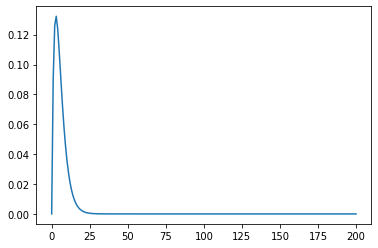

In [23]:
plt.plot(gen_distribution(1,0.3,200))

In [11]:
def sample(dist):
    r = random.random()
    tot = 0.0
    ind = 0
    while tot < r:
        tot += dist[ind]
        ind +=1
    return ind

In [12]:
def est_dist(degs,freqs,p,n):
    isolates = n - sum(freqs)
    newdegs = []
    degs.append(0)
    freqs.append(isolates)
    for i in range(len(degs)):
        k = int(degs[i])
        kmax = int(1/p * k + 100)
        fr = freqs[i]
        dist = gen_distribution(k,p,kmax)
        for _ in range(fr):
            newdegs.append(sample(dist))
    # Correction step to ensure right number of edges in total
#     correct_degsum = int(1/p * sum(degs))
#     for i in range(max(0,correct_degsum - sum(newdegs))):
#         j = random.randint(0,len(newdegs)-1)
#         if newdegs[j]>0:
#             newdegs[j]-=1
    return newdegs

In [100]:
G = nx.barabasi_albert_graph(10000,3)
p=0.01
H = edge_sample(G,p)
c = Counter([d for n,d in H.degree()])
degs = sorted(c.keys())
vals = [c[val] for val in degs]

newdegs = est_dist(degs,vals,p,len(G.nodes()))

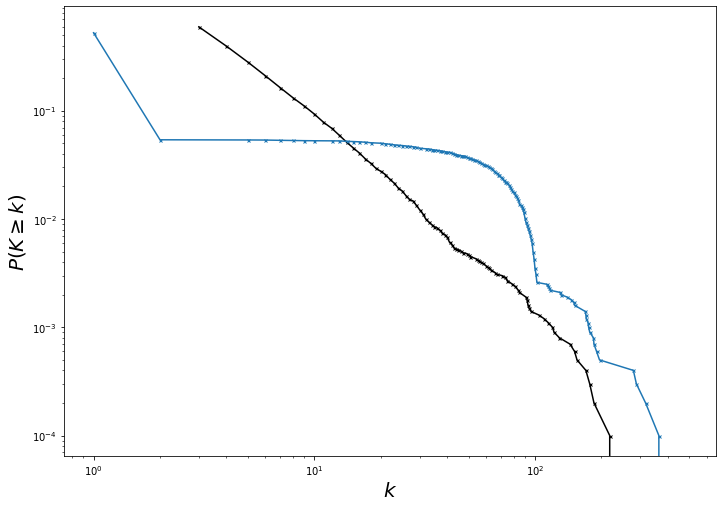

In [98]:
fig, ax = setup_axes('$k$','$P(K\\geq k)$','log','log')
rdegs, rcdf = get_deg_cdf(G)
rcdf = 1 - rcdf/rcdf[-1]
degs, cdf = ecdf(newdegs)
ccdf = 1 - cdf/cdf[-1]

ax.plot(rdegs, rcdf,marker='x',markersize=3,label="real",color='black')
ax.plot(degs, ccdf,marker='x',markersize=3,label="p="+str(0.8))

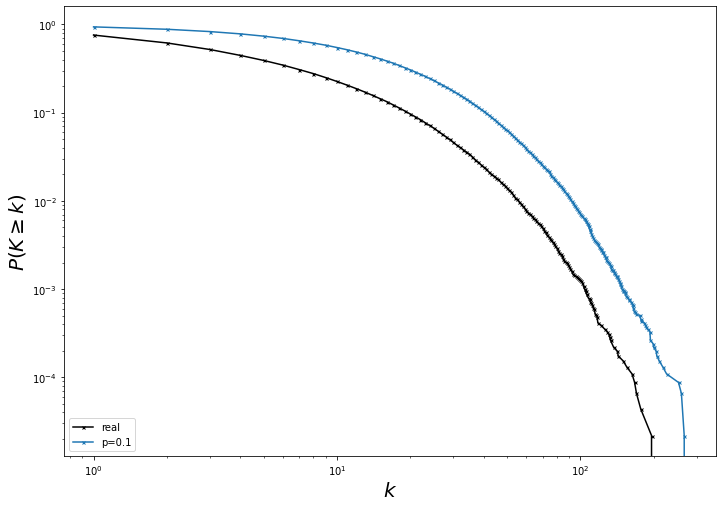

In [102]:
fname="/Users/narnolddd/CODE/FETA/FETA3/data/facebook.dat"
net = pd.read_csv(fname,sep=" ",names=["source","target","t"])
net = net.drop(["t"], axis=1)
G = nx.from_pandas_edgelist(net)

p=0.1
H = edge_sample(G,p)
c = Counter([d for n,d in H.degree()])
degs = sorted(c.keys())
vals = [c[val] for val in degs]

newdegs = est_dist(degs,vals,p,len(G.nodes()))

fig, ax = setup_axes('$k$','$P(K\\geq k)$','log','log')
rdegs, rcdf = get_deg_cdf(G)
#rcdf = rcdf[-1] - rcdf
rcdf = 1 - rcdf/rcdf[-1]

degs, cdf = ecdf(newdegs)
#ccdf = cdf[-1] - cdf
ccdf = 1 - cdf/cdf[-1]

ax.plot(rdegs, rcdf,marker='x',markersize=3,label="real",color='black')
ax.plot(degs, ccdf,marker='x',markersize=3,label="p="+str(p))
ax.legend(loc="lower left")
plt.show()

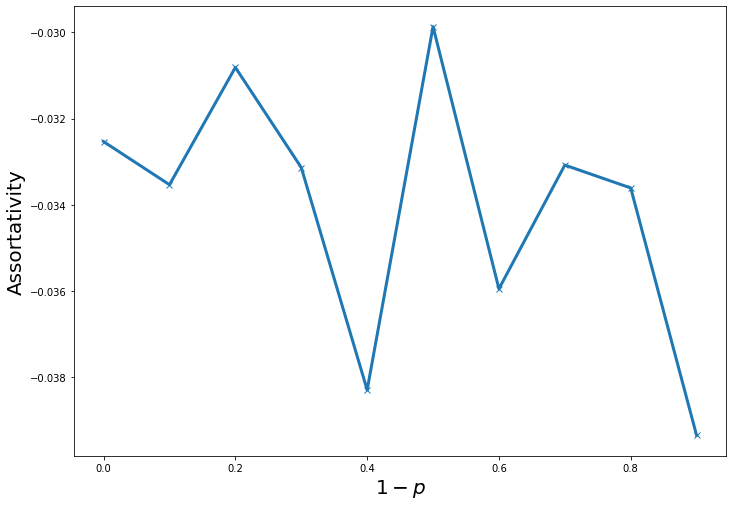

In [132]:
fig, ax = plt.subplots(figsize = a4_dims)

ax.set_xlabel('$1-p$',fontsize=20)
ax.set_ylabel('Assortativity', fontsize=20)

prange = np.linspace(0.1,1.0,10)
y = np.zeros(len(prange))

for i in range(len(prange)-1):
    p = prange[i]
    H = edgesample(G,p)
    tri = nx.degree_assortativity_coefficient(H)
    y[i]=tri

y[-1] = nx.degree_assortativity_coefficient(G)
q = 1-prange

ax.plot(q,y,marker='x',linewidth=3)
plt.show()

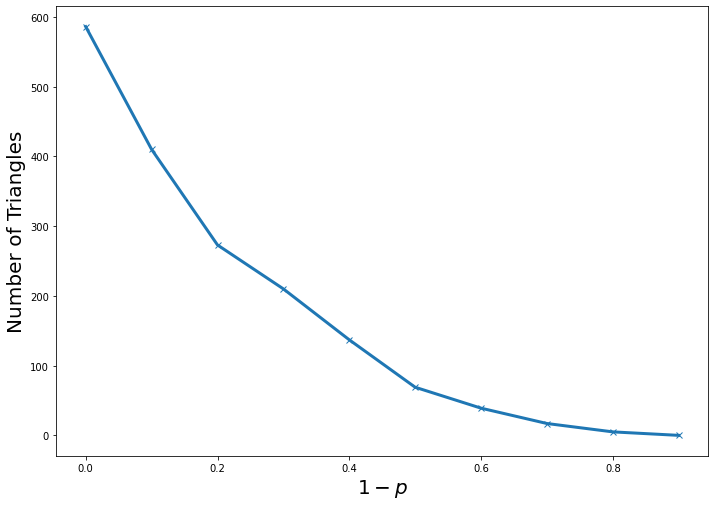

In [25]:
fig, ax = plt.subplots(figsize = a4_dims)

# fname="/Users/narnolddd/CODE/FETA/FETA3/data/facebook.dat"
# net = pd.read_csv(fname,sep=" ",names=["source","target","t"])
# net = net.drop(["t"], axis=1)
# G = nx.from_pandas_edgelist(net)

ax.set_xlabel('$1-p$',fontsize=20)
ax.set_ylabel('Number of Triangles', fontsize=20)

prange = np.linspace(0.1,1.0,10)
y = np.zeros(len(prange))

for i in range(len(prange)-1):
    p = prange[i]
    H = edge_sample(G,p)
    tri = sum(nx.triangles(H).values()) / 3
    y[i]=tri

y[-1]=sum(nx.triangles(G).values()) / 3
q = 1-prange

ax.plot(q,y,marker='x',linewidth=3)
plt.show()